In [1]:
#import sys
#sys.version

## Import modules

In [2]:
# fundamentals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation, optimization, metrics
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# custom
from global_settings import *
from functions import *

## Prepare f2 metric

In [3]:
from sklearn.metrics import make_scorer,fbeta_score
def f2_score(y_true, y_pred):
    score = fbeta_score(y_true, y_pred, beta=2)
    return score

def f2():
    return make_scorer(f2_score)

## Load, clean and split the data

In [4]:
raw_data = pd.read_csv("../Data/HR_Analytics.csv")

In [5]:
# Assign columns to column groups
catcols = ["AgeGroup", "SalarySlab", "Department", "EducationField", "JobRole", "MaritalStatus"]
numcols = ["Education", "EnvironmentSatisfaction", "BusinessTravel", "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating", 
           "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance", "OverTime", "Gender", "Age", "DailyRate", "DistanceFromHome", 
           "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
           "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
delcols = ["EmpID", "EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"]

# clean data
def clean_data(DF, delcols=delcols):
    df = DF.drop_duplicates()
    df = df.drop(delcols, axis=1)
    df = df.replace({"Yes": 1,
                     "No": 0,
                     "Female": 1,
                     "Male": 0,
                     "Non-Travel": 0,
                     "TravelRarely": 1,
                     "Travel_Rarely": 1,
                     "Travel_Frequently": 2})
    #df = df.dropna(axis=0)
    return df

data = clean_data(raw_data)

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop("Attrition", axis=1), 
                                                data["Attrition"], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data["Attrition"], 
                                                random_state=0)

In [6]:
#Xtrain.info()

## Prepare preprocessing

In [7]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy="median")
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([("imputer", simpimp),
                    ("scaler", std)])

coltrans = ColumnTransformer(transformers=[("encoder", encoder, catcols),
                                           ("numpipe", numpipe, numcols)])
selection = SelectPercentile(percentile=90) # percentile=10

## Import available models and settings

In [8]:
from models import *
print(f"Models that are available: {list(model_settings.keys())}")

Models that are available: ['svc', 'xgb', 'rfc']


## Choose model

In [9]:
chosen_model = "rfc"
# Define models and params / search space in models.py

## Prepare grid search

In [10]:
model = model_settings[chosen_model]['model']
search_space = model_settings[chosen_model]['params']

# Outcomment search_space and 'selector' if SelectPercentile is not to be applied
#search_space["selector__percentile"] = [70, 75, 80, 85, 90, 95, 100]
pipe = Pipeline([('prepper', coltrans),
#                 ("selector", selection),
                 ('estimator', model)])

## Run grid search

Fitting 6 folds for each of 1 candidates, totalling 6 fits


C:\Users\osmin\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'estimator__class_weight': 'balanced', 'estimator__max_depth': 10, 'estimator__max_samples': None, 'estimator__min_samples_leaf': 8, 'estimator__n_estimators': 60}
Best F2 score: 45.87%
--------------------------------------------------------
F2 score on test set:	45.45%
Recall on test set:	44.68%
Precision on test set:	48.84%


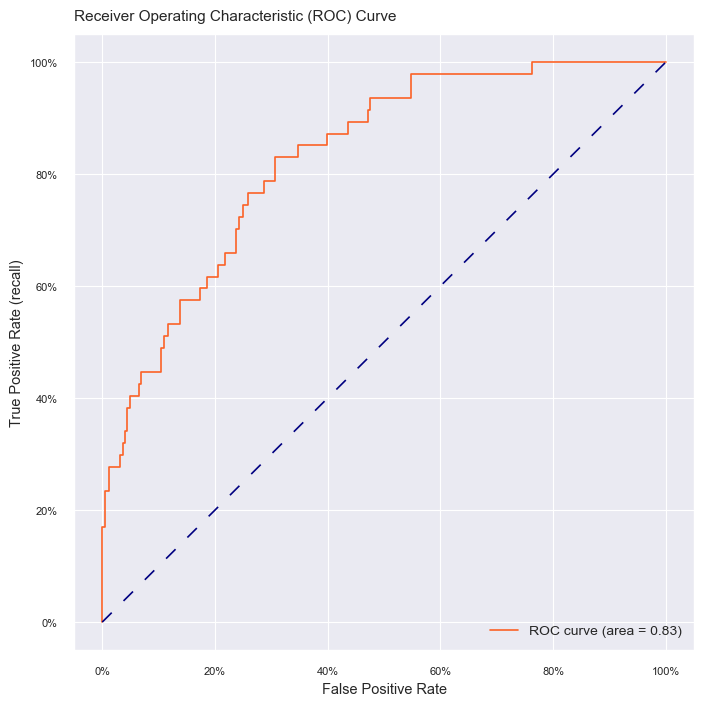

In [11]:
best_pipe = GridSearchCV(estimator=pipe,
                         param_grid=search_space,
                         scoring=f2(),
                         cv=6,
                         verbose=3,
                         n_jobs=-1)
best_pipe.fit(Xtrain, ytrain)
print(best_pipe.best_params_)
print(f"Best F2 score: {best_pipe.best_score_.mean():.2%}")
print("--------------------------------------------------------")
ypred = best_pipe.predict(Xtest)
print(f"F2 score on test set:\t{f2_score(ytest, ypred):.2%}")
print(f"Recall on test set:\t{recall_score(ytest, ypred):.2%}")
print(f"Precision on test set:\t{precision_score(ytest, ypred):.2%}")
plot_roc(best_pipe, Xtest, ytest)

In [12]:
results = pd.DataFrame(best_pipe.cv_results_).sort_values(by="mean_test_score", ascending=False).head(8)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__class_weight,param_estimator__max_depth,param_estimator__max_samples,param_estimator__min_samples_leaf,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.15,0.01,0.01,0.00,balanced,10,None,8,60,"{'estimator__class_weight': 'balanced', 'estim...",0.59,0.45,0.38,0.46,0.42,0.45,0.46,0.06,1


[Text(0.0, 1.0, 'Features sorted by permutation importance'),
 Text(0.5, 0, 'Permutation Importance')]

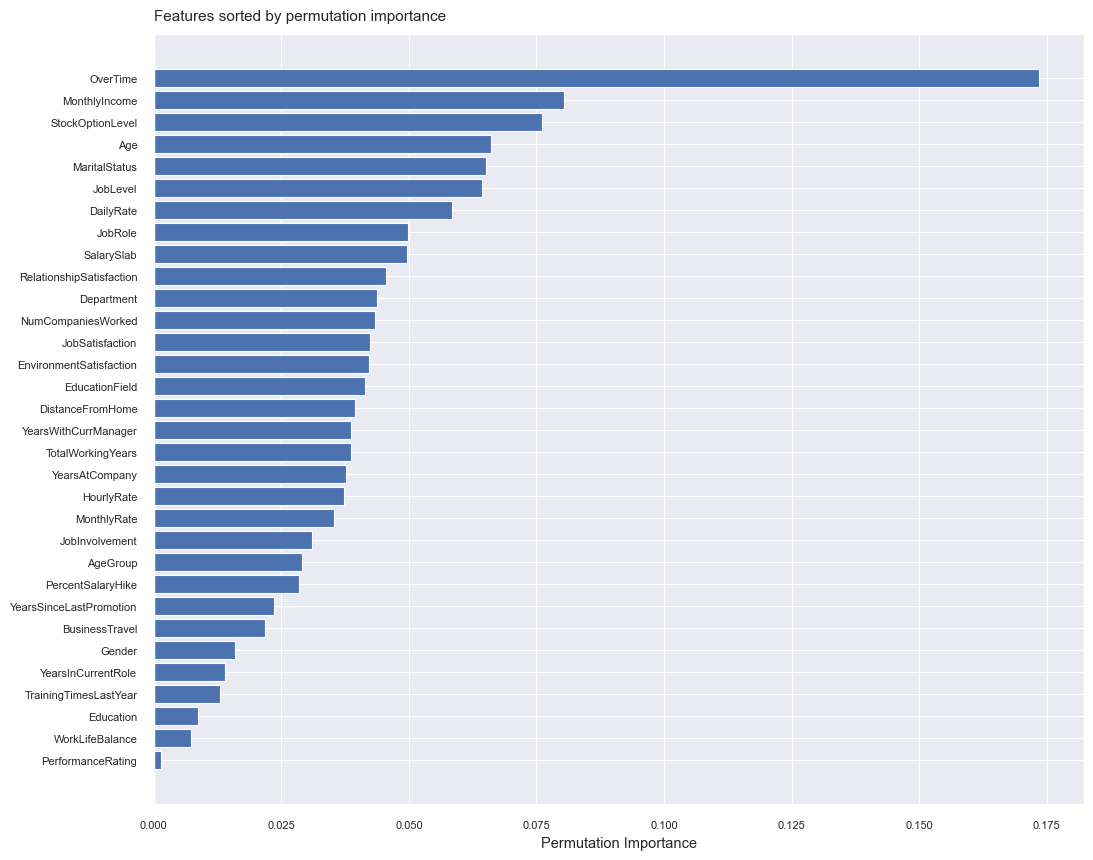

In [13]:
# Estimate feature importance through permutation importance
result = permutation_importance(best_pipe, Xtrain, ytrain, n_repeats=20, random_state=42)
importance_scores = abs(result.importances_mean)
original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

# Plot it
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(orig_sorted_features, orig_sorted_importance)
ax.set(title="Features sorted by permutation importance",
      xlabel="Permutation Importance")